In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# Load the data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [3]:
# Merge customer profile with transaction data
merged_data = pd.merge(transactions, customers, on="CustomerID")

# Feature Engineering

In [4]:
# Total spending, number of transactions, and unique products
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',   # Total spending
    'Quantity': 'sum',     # Total quantity purchased
    'ProductID': pd.Series.nunique,  # Unique products bought
    'TransactionID': 'count'  # Number of transactions
}).reset_index()

In [5]:
# Customer Profile Features: Region and SignupDate
profile_features = customers[['CustomerID', 'Region', 'SignupDate']]

In [7]:
# Convert signup date to days since signup
profile_features['SignupDate'] = pd.to_datetime(profile_features['SignupDate'])
profile_features.loc[:, 'DaysSinceSignup'] = (pd.to_datetime('today') - profile_features['SignupDate']).dt.days

In [8]:
# One-hot encoding for 'Region'
profile_features = pd.get_dummies(profile_features, columns=['Region'], drop_first=True)

In [9]:
# Merge the profile features with transaction features
final_features = pd.merge(customer_features, profile_features, on='CustomerID')

In [11]:
# Drop the date-related column(s)
features_to_scale = final_features.drop(['CustomerID', 'DaysSinceSignup', 'SignupDate'], axis=1)

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_to_scale)

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Choose number of clusters between 2 and 10 (e.g., 4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_features)

# Add cluster labels to the dataframe
final_features['Cluster'] = kmeans.labels_

# Calculate DB Index and Silhouette Score for evaluation
db_index = davies_bouldin_score(scaled_features, kmeans.labels_)
silhouette_avg = silhouette_score(scaled_features, kmeans.labels_)

print(f"DB Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")


DB Index: 1.1660094885100918
Silhouette Score: 0.3252531310797527


Interpretation of Results:

**DB Index:** A value of 1.17 suggests that the clusters are somewhat well-separated but could be improved. Generally, a DB Index closer to 0 indicates better clustering, so you might experiment with tuning the number of clusters or using different clustering algorithms (e.g., DBSCAN or Agglomerative Clustering) to achieve a lower DB Index.

**Silhouette Score:** A score of 0.33 indicates that the clusters are not perfectly distinct but still show some level of separation. A silhouette score close to 1 would indicate very well-separated clusters, so there is room for improvement.

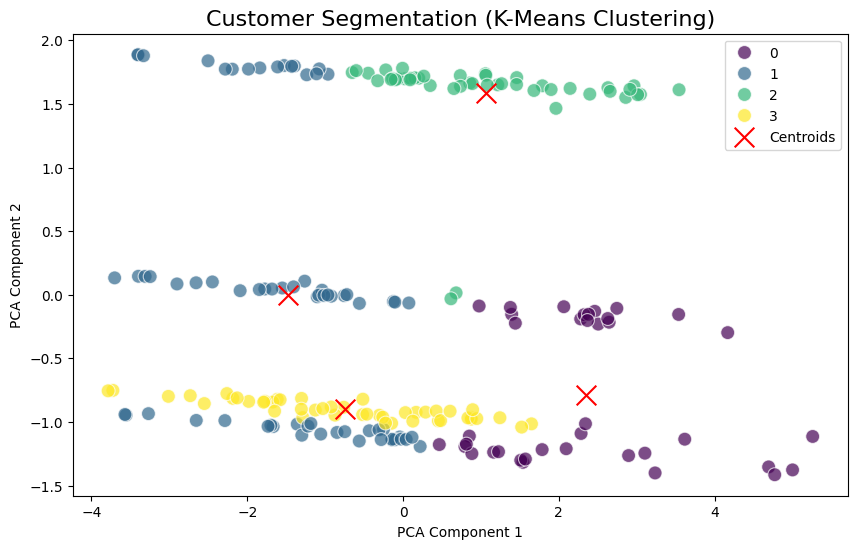

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=final_features['Cluster'], palette='viridis', s=100, alpha=0.7)

# Add cluster centers
centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=200, label='Centroids')

plt.title('Customer Segmentation (K-Means Clustering)', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


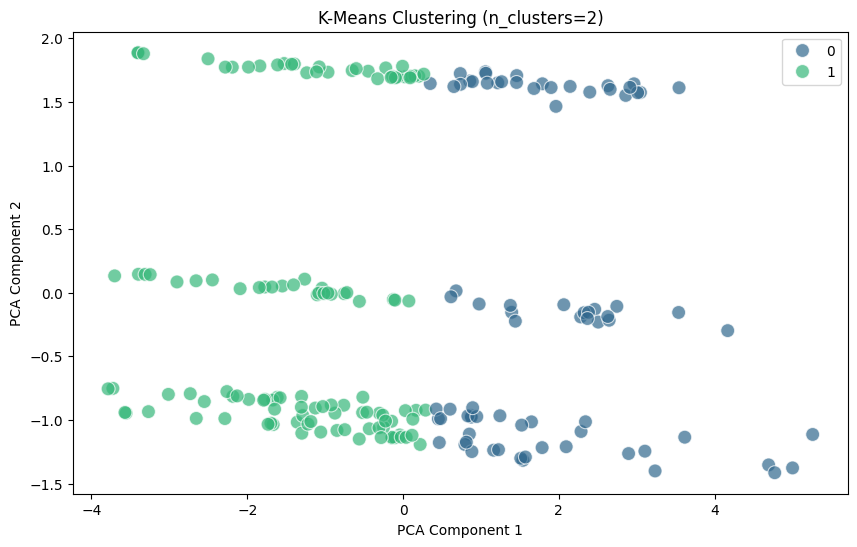

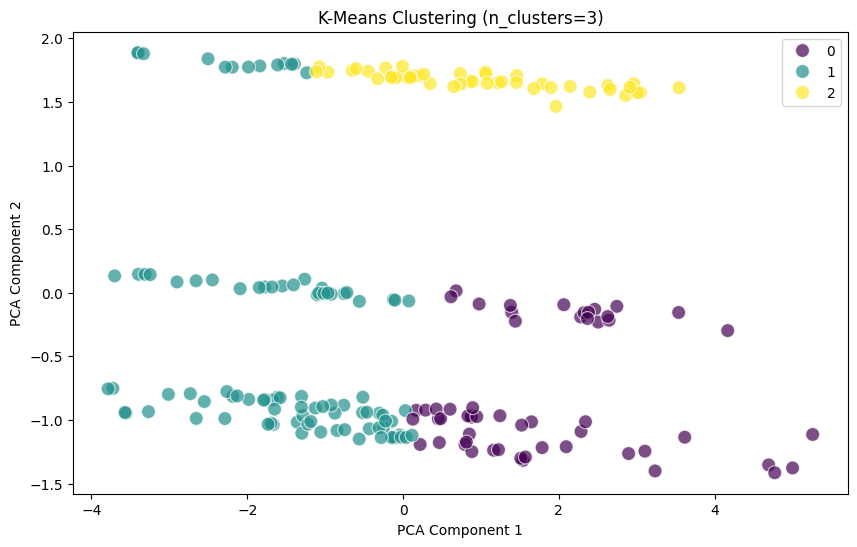

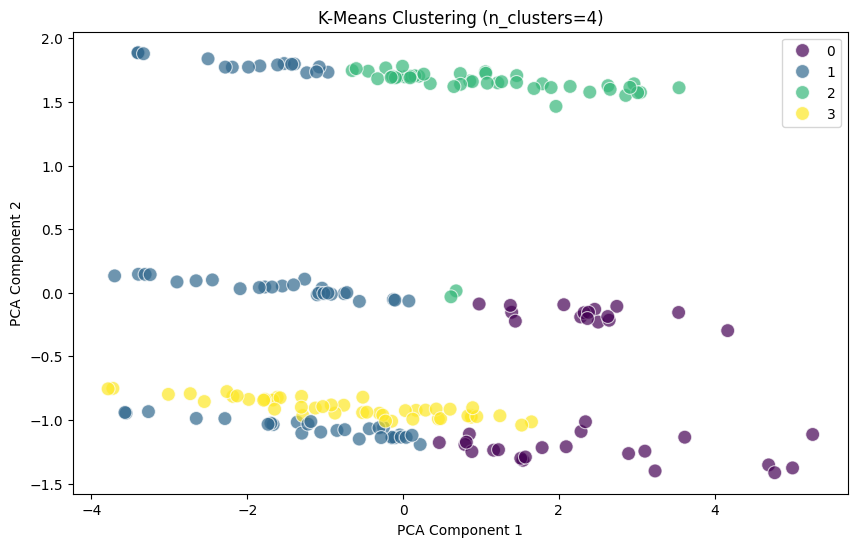

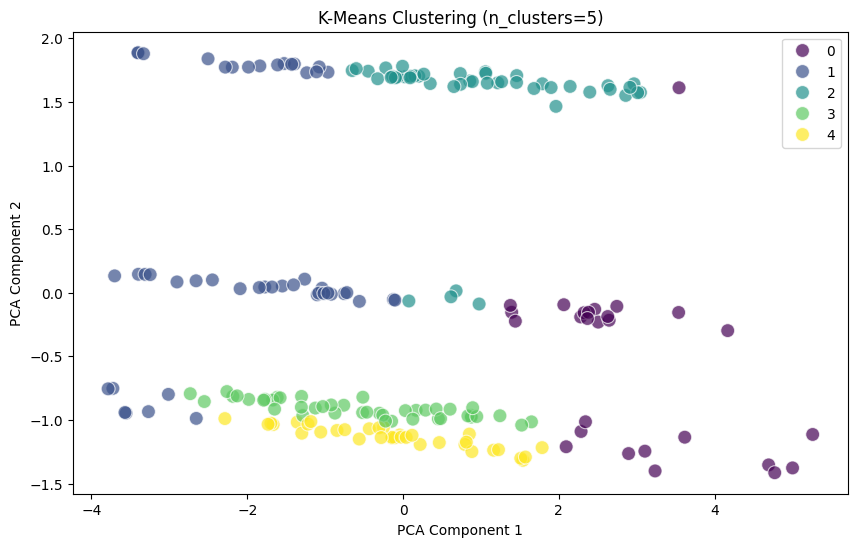

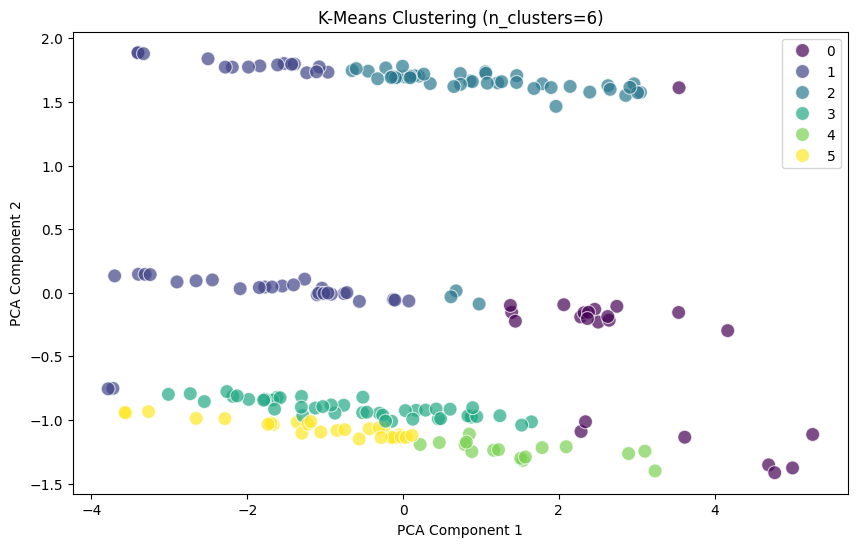

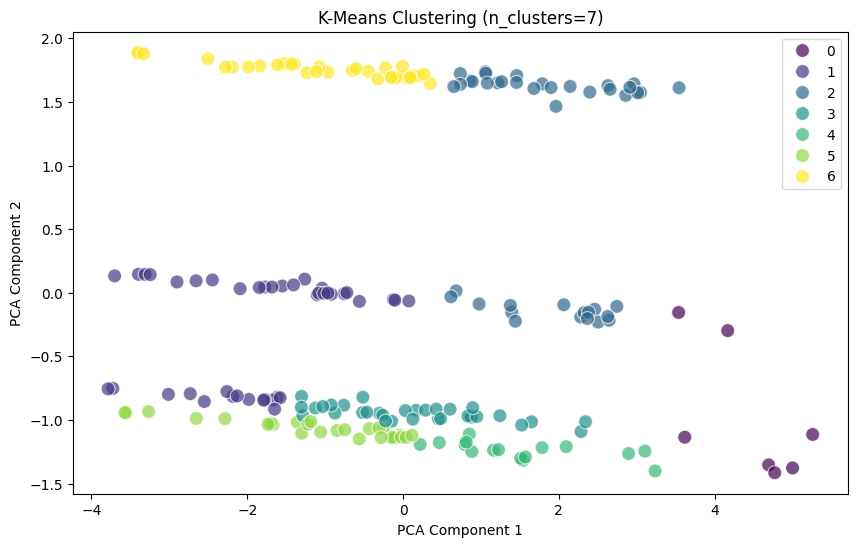

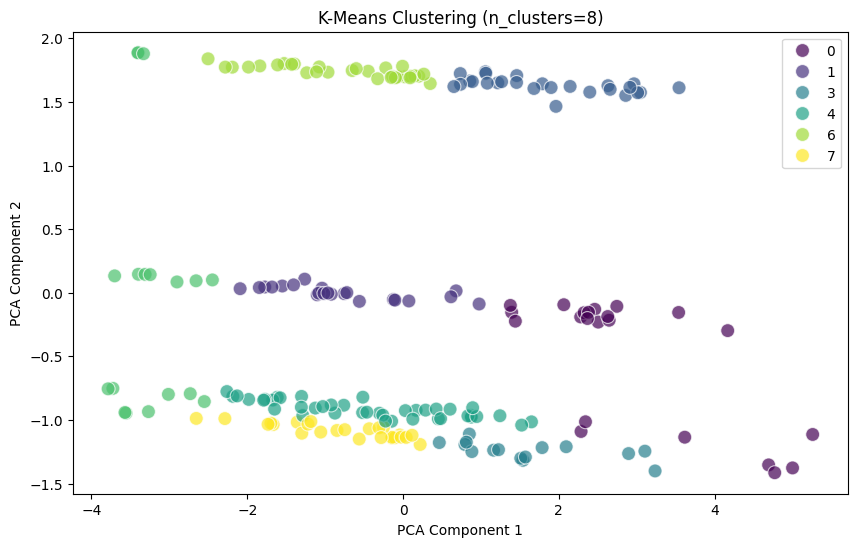

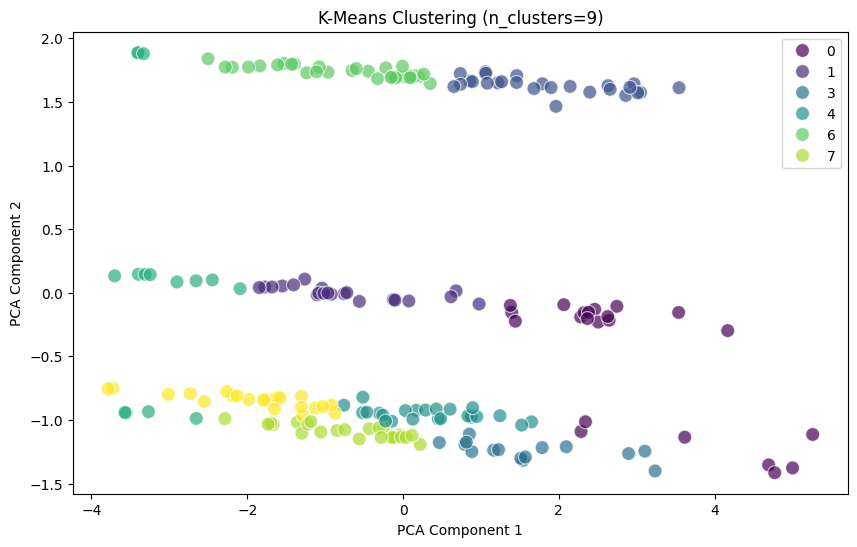

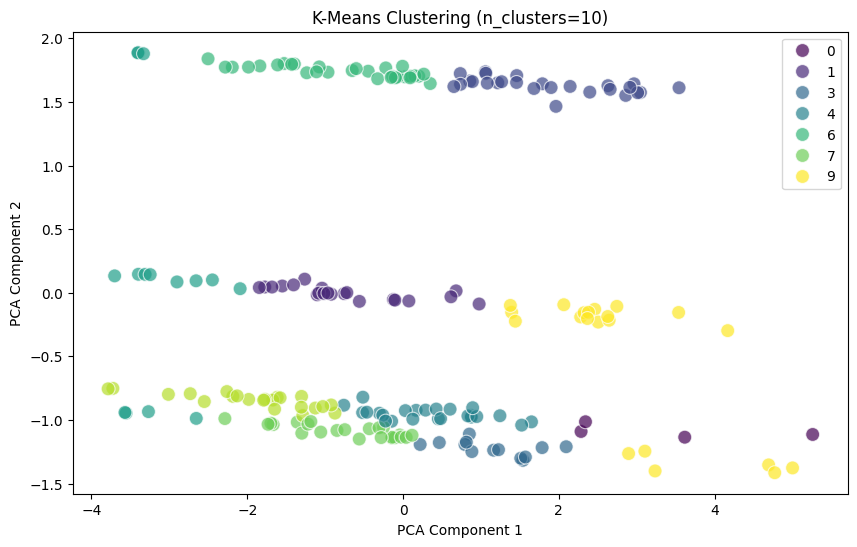

Number of Clusters: 2
DB Index: 1.3355580113483516
Silhouette Score: 0.2883932872194974

Number of Clusters: 3
DB Index: 1.2479796060373944
Silhouette Score: 0.2808976230004989

Number of Clusters: 4
DB Index: 1.1660094885100918
Silhouette Score: 0.3252531310797527

Number of Clusters: 5
DB Index: 1.0225829382285823
Silhouette Score: 0.36960890322664336

Number of Clusters: 6
DB Index: 1.0259653174044874
Silhouette Score: 0.35865528911097727

Number of Clusters: 7
DB Index: 1.0113552404592547
Silhouette Score: 0.34931591973142595

Number of Clusters: 8
DB Index: 0.939877688488796
Silhouette Score: 0.3795443224804605

Number of Clusters: 9
DB Index: 0.8986731720164465
Silhouette Score: 0.3930624397741179

Number of Clusters: 10
DB Index: 0.9146286466490942
Silhouette Score: 0.38995744928905135



In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Try different values of n_clusters between 2 and 10 for K-Means
cluster_numbers = range(2, 11)

# Prepare a list to store the results for K-Means
kmeans_results = []

for n_clusters in cluster_numbers:
    # Fit K-Means Clustering with n_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(scaled_features)

    # Evaluate clustering
    db_index_kmeans = davies_bouldin_score(scaled_features, kmeans_labels)
    silhouette_avg_kmeans = silhouette_score(scaled_features, kmeans_labels)

    # Save the results
    kmeans_results.append({
        'n_clusters': n_clusters,
        'DB Index': db_index_kmeans,
        'Silhouette Score': silhouette_avg_kmeans
    })

    # Visualize clusters with PCA
    pca_result_kmeans = pca.fit_transform(scaled_features)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=pca_result_kmeans[:, 0], y=pca_result_kmeans[:, 1], hue=kmeans_labels, palette='viridis', s=100, alpha=0.7)
    plt.title(f'K-Means Clustering (n_clusters={n_clusters})')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# Print the results for K-Means
for result in kmeans_results:
    print(f"Number of Clusters: {result['n_clusters']}")
    print(f"DB Index: {result['DB Index']}")
    print(f"Silhouette Score: {result['Silhouette Score']}\n")


In [14]:
# Save the clustering results to a CSV file
final_features[['CustomerID', 'Cluster']].to_csv('Customer_Segmentation.csv', index=False)

# Report on clustering results
report = f"""
Number of Clusters: {kmeans.n_clusters}
DB Index: {db_index}
Silhouette Score: {silhouette_avg}
"""
with open('Clustering_Report.txt', 'w') as f:
    f.write(report)

print("Clustering results saved to 'Customer_Segmentation.csv' and 'Clustering_Report.txt'")


Clustering results saved to 'Customer_Segmentation.csv' and 'Clustering_Report.txt'


#experiment with other clustering algorithms

DBSCAN (Density-Based Spatial Clustering)

Steps:
1. DBSCAN parameters:

a.eps: Maximum distance between two samples for one to be considered as in the neighborhood of the other.
b.min_samples: The number of points required to form a dense region (cluster).

2. Evaluate with DB Index and Silhouette Score.

In [15]:
from sklearn.cluster import DBSCAN

In [16]:
# Fit DBSCAN model (experiment with different eps and min_samples)
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_features)

In [17]:
# Add cluster labels to the dataframe
final_features['DBSCAN_Cluster'] = dbscan_labels

In [18]:
# Evaluate DBSCAN clustering using DB Index and Silhouette Score
db_index_dbscan = davies_bouldin_score(scaled_features, dbscan_labels)
silhouette_avg_dbscan = silhouette_score(scaled_features, dbscan_labels)

In [19]:
print(f"DB Index (DBSCAN): {db_index_dbscan}")
print(f"Silhouette Score (DBSCAN): {silhouette_avg_dbscan}")

DB Index (DBSCAN): 1.4718200174057012
Silhouette Score (DBSCAN): -0.20997351111592172


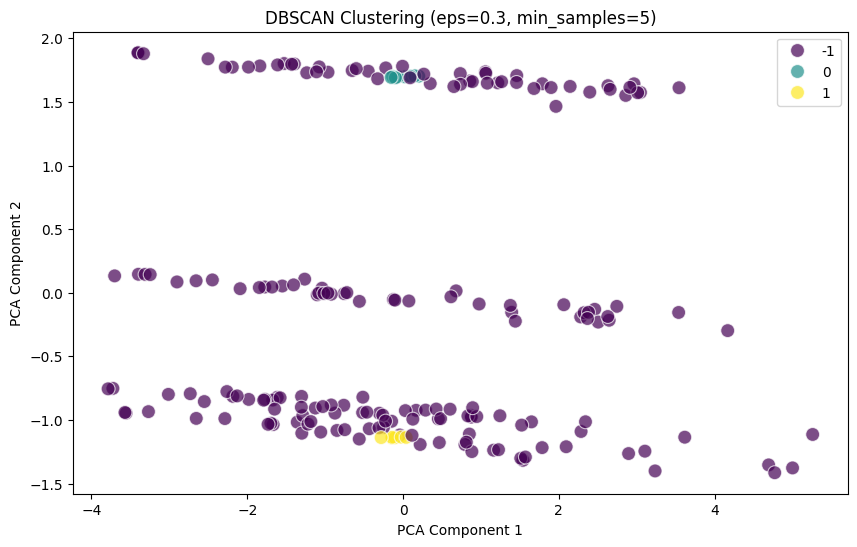

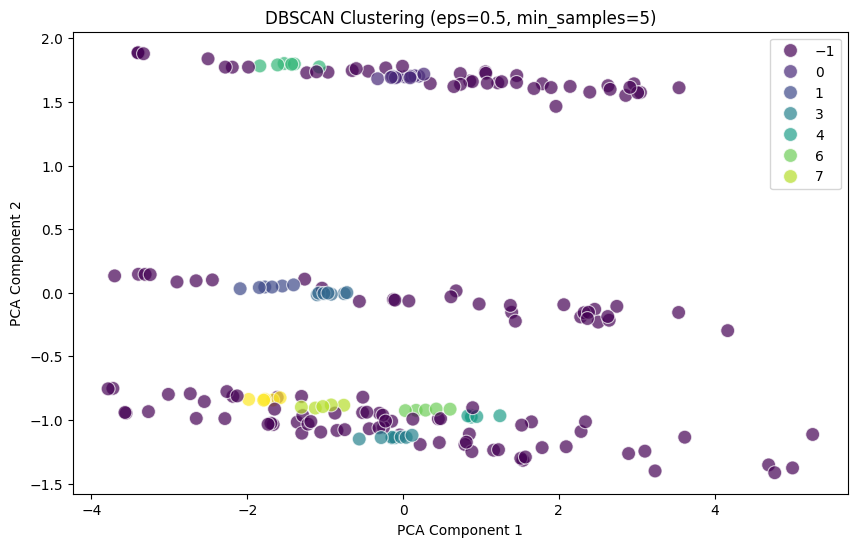

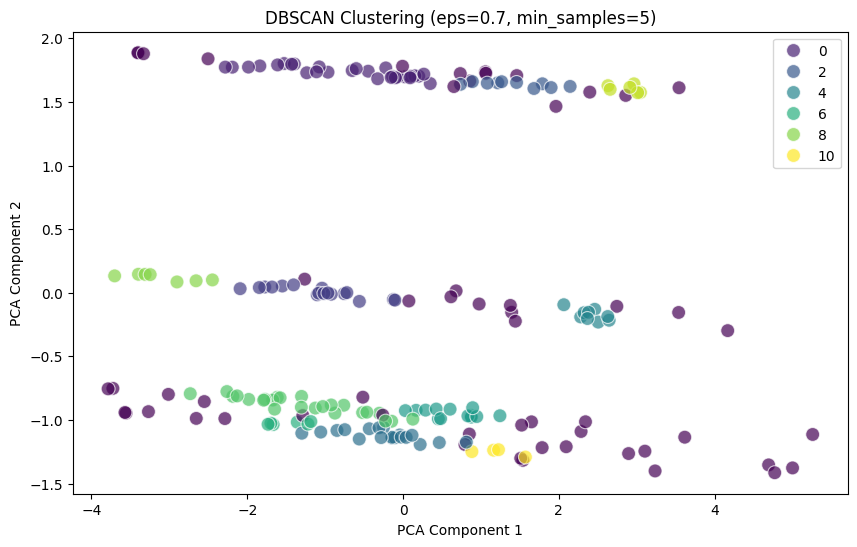

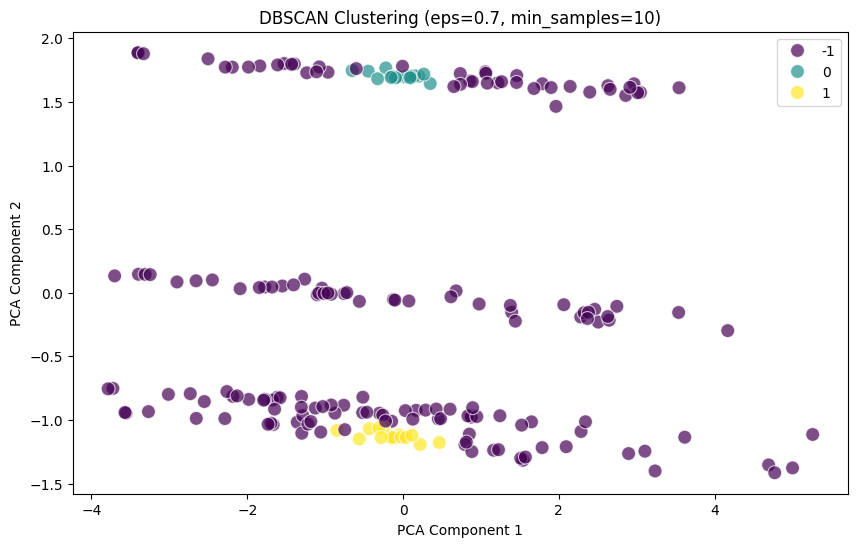

eps: 0.3, min_samples: 5
DB Index: 1.4679481536398449
Silhouette Score: -0.18438636600981995

eps: 0.5, min_samples: 5
DB Index: 1.4718200174057012
Silhouette Score: -0.20997351111592172

eps: 0.7, min_samples: 5
DB Index: 1.5393409378805745
Silhouette Score: 0.16582707375987019

eps: 0.7, min_samples: 10
DB Index: 1.5991680264648906
Silhouette Score: -0.06383283161741783



In [31]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Try different values of eps and min_samples for DBSCAN
eps_values = [0.3, 0.5, 0.7]
min_samples_values = [5, 10, 15]

# Prepare a list to store the results for DBSCAN
dbscan_results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        # Fit DBSCAN Clustering
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(scaled_features)

        # Evaluate clustering only if DBSCAN finds more than 1 cluster
        if len(set(dbscan_labels)) > 1:  # Avoid evaluating if DBSCAN finds only one cluster (outliers)
            db_index_dbscan = davies_bouldin_score(scaled_features, dbscan_labels)
            silhouette_avg_dbscan = silhouette_score(scaled_features, dbscan_labels)

            # Save the results
            dbscan_results.append({
                'eps': eps,
                'min_samples': min_samples,
                'DB Index': db_index_dbscan,
                'Silhouette Score': silhouette_avg_dbscan
            })

            # Visualize clusters with PCA
            pca_result_dbscan = pca.fit_transform(scaled_features)
            plt.figure(figsize=(10, 6))
            sns.scatterplot(x=pca_result_dbscan[:, 0], y=pca_result_dbscan[:, 1], hue=dbscan_labels, palette='viridis', s=100, alpha=0.7)
            plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples})')
            plt.xlabel('PCA Component 1')
            plt.ylabel('PCA Component 2')
            plt.show()

# Print the results for DBSCAN
for result in dbscan_results:
    print(f"eps: {result['eps']}, min_samples: {result['min_samples']}")
    print(f"DB Index: {result['DB Index']}")
    print(f"Silhouette Score: {result['Silhouette Score']}\n")


Agglomerative Clustering (Hierarchical Clustering)

Steps:
1.Agglomerative Clustering doesn't require you to specify the number of clusters upfront. You can control the desired number of clusters by setting the n_clusters parameter or defining a distance threshold.

2.Evaluate with DB Index and Silhouette Score.

In [20]:
from sklearn.cluster import AgglomerativeClustering

In [21]:
# Fit Agglomerative Clustering model (experiment with different n_clusters)
agg_clustering = AgglomerativeClustering(n_clusters=4)  # Change this to test different numbers
agg_labels = agg_clustering.fit_predict(scaled_features)

In [22]:
# Add cluster labels to the dataframe
final_features['Agglomerative_Cluster'] = agg_labels

In [23]:
# Evaluate Agglomerative Clustering using DB Index and Silhouette Score
db_index_agg = davies_bouldin_score(scaled_features, agg_labels)
silhouette_avg_agg = silhouette_score(scaled_features, agg_labels)

In [24]:
print(f"DB Index (Agglomerative): {db_index_agg}")
print(f"Silhouette Score (Agglomerative): {silhouette_avg_agg}")

DB Index (Agglomerative): 1.0140196078377843
Silhouette Score (Agglomerative): 0.33625713772201976


Compare Results

After running these two clustering algorithms (DBSCAN and Agglomerative), compare their DB Index and Silhouette Score:

1. The DB Index should be lower (preferably closer to 0) for better clustering.

2. The Silhouette Score should be higher (closer to 1) for more well-separated clusters.

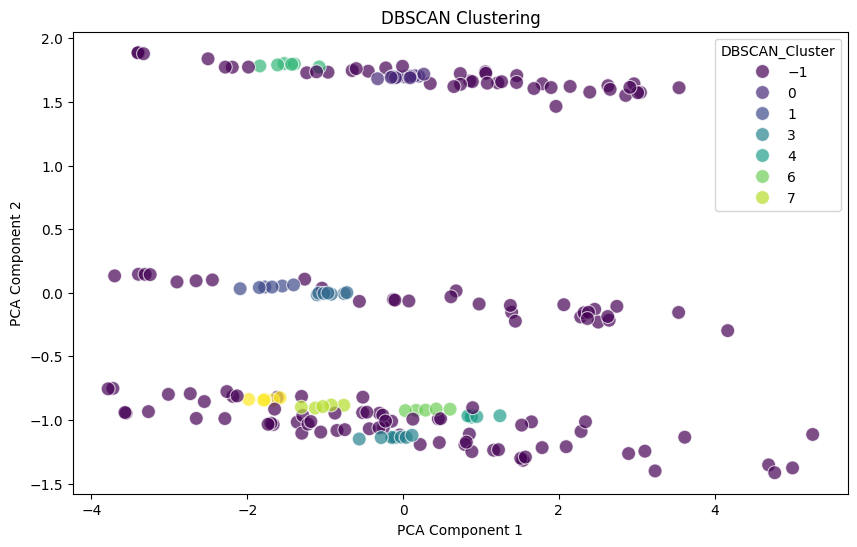

In [25]:
# Visualize DBSCAN clusters
pca_result_dbscan = pca.fit_transform(scaled_features)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result_dbscan[:, 0], y=pca_result_dbscan[:, 1], hue=final_features['DBSCAN_Cluster'], palette='viridis', s=100, alpha=0.7)
plt.title('DBSCAN Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

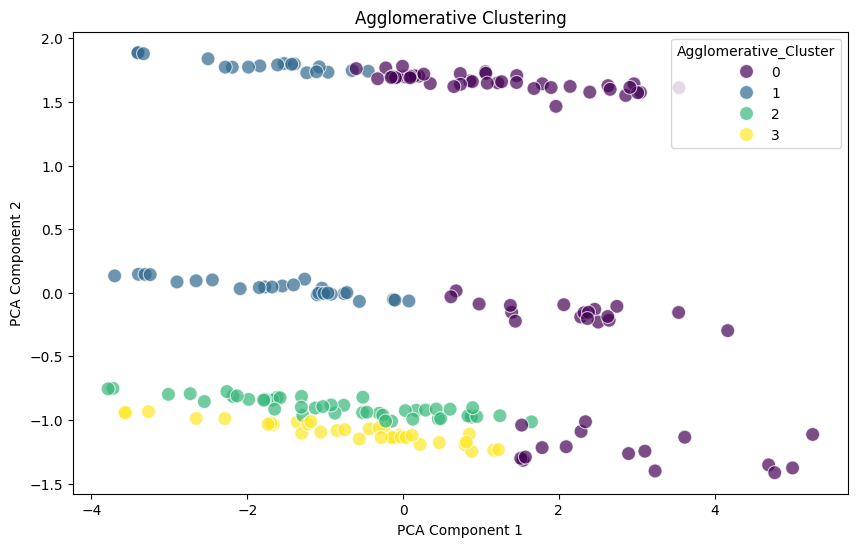

In [26]:
# Visualize Agglomerative clusters
pca_result_agg = pca.fit_transform(scaled_features)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result_agg[:, 0], y=pca_result_agg[:, 1], hue=final_features['Agglomerative_Cluster'], palette='viridis', s=100, alpha=0.7)
plt.title('Agglomerative Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

Number of Clusters: 2
DB Index: 1.394820798054846
Silhouette Score: 0.27799577587519114



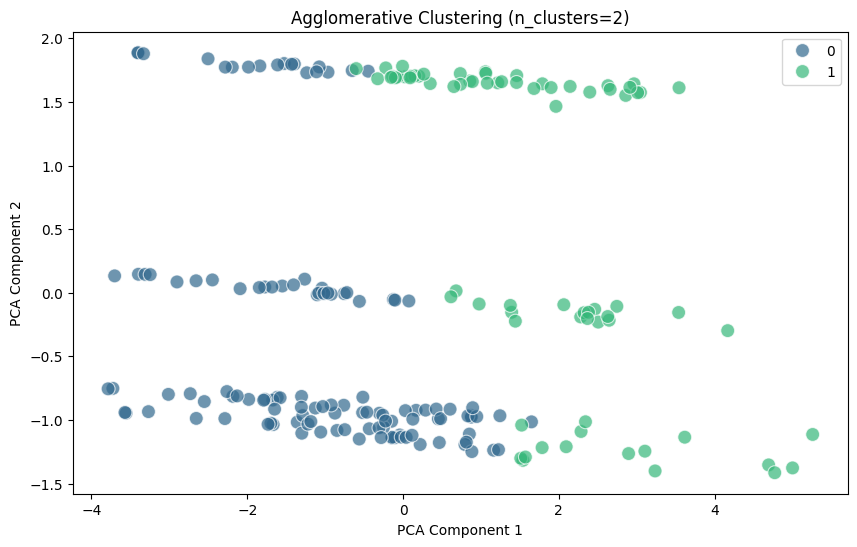

Number of Clusters: 3
DB Index: 1.2374205740671276
Silhouette Score: 0.30041817604634014



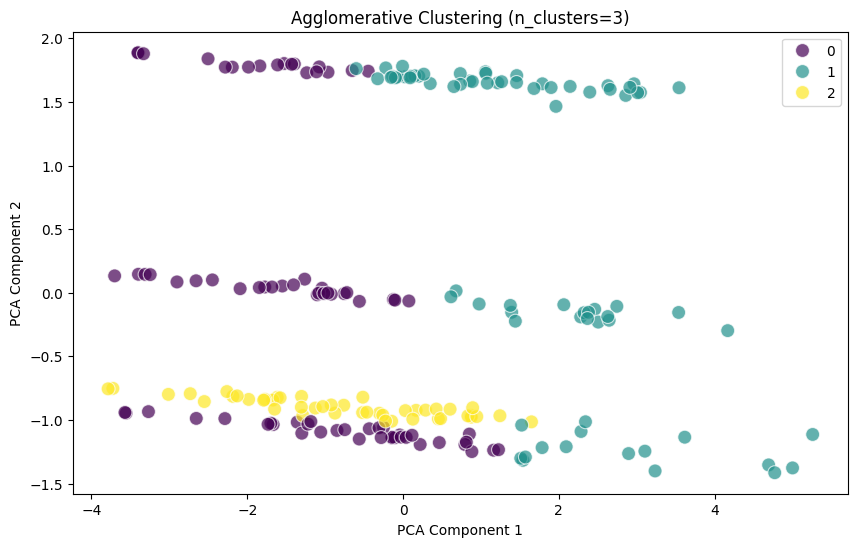

Number of Clusters: 4
DB Index: 1.0140196078377843
Silhouette Score: 0.33625713772201976



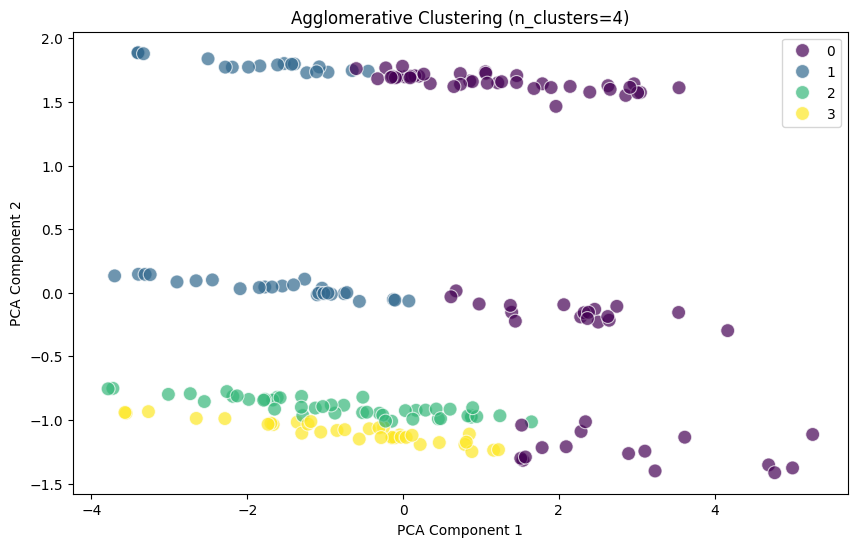

Number of Clusters: 5
DB Index: 1.0566302950124862
Silhouette Score: 0.36475953155226876



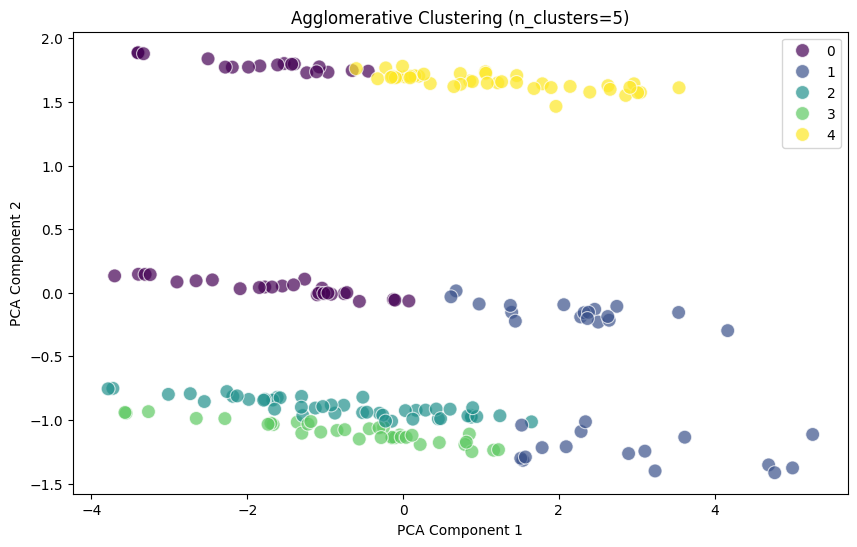

Number of Clusters: 6
DB Index: 0.9620455955796446
Silhouette Score: 0.36302986051926933



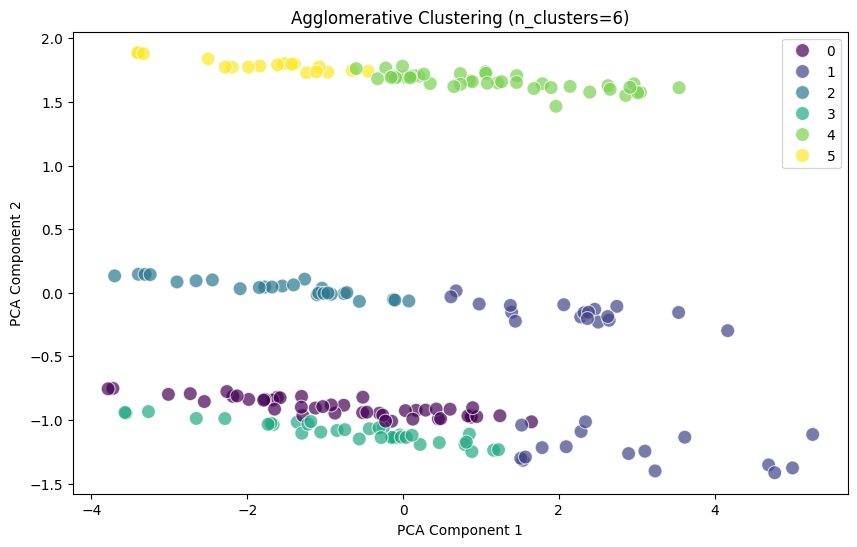

Number of Clusters: 7
DB Index: 0.9300212261376622
Silhouette Score: 0.36463758726814494



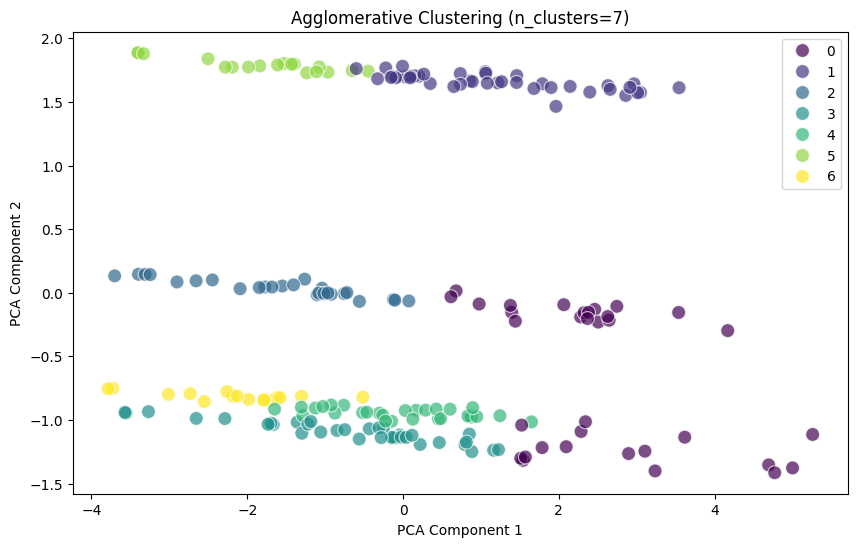

Number of Clusters: 8
DB Index: 0.9470400425009287
Silhouette Score: 0.37201150883648393



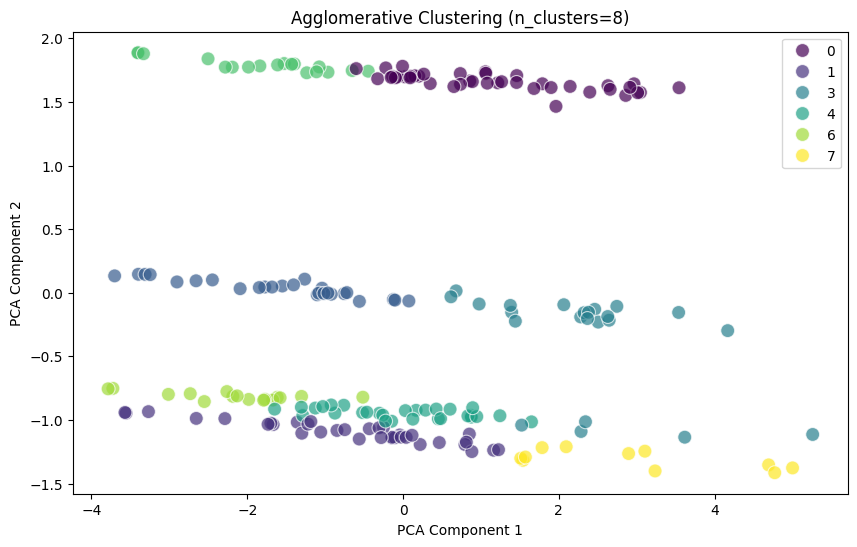

Number of Clusters: 9
DB Index: 0.9295574003082385
Silhouette Score: 0.37729844162268833



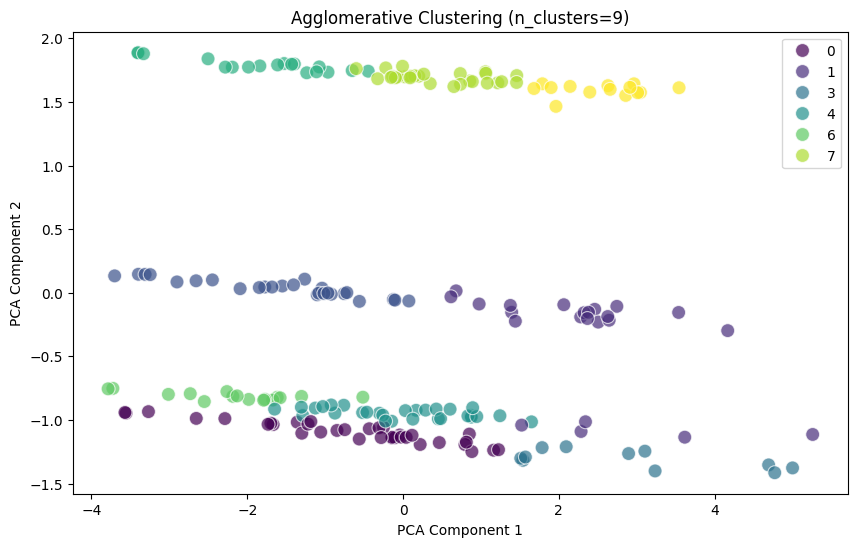

Number of Clusters: 10
DB Index: 0.8901639873683415
Silhouette Score: 0.38199357273918544



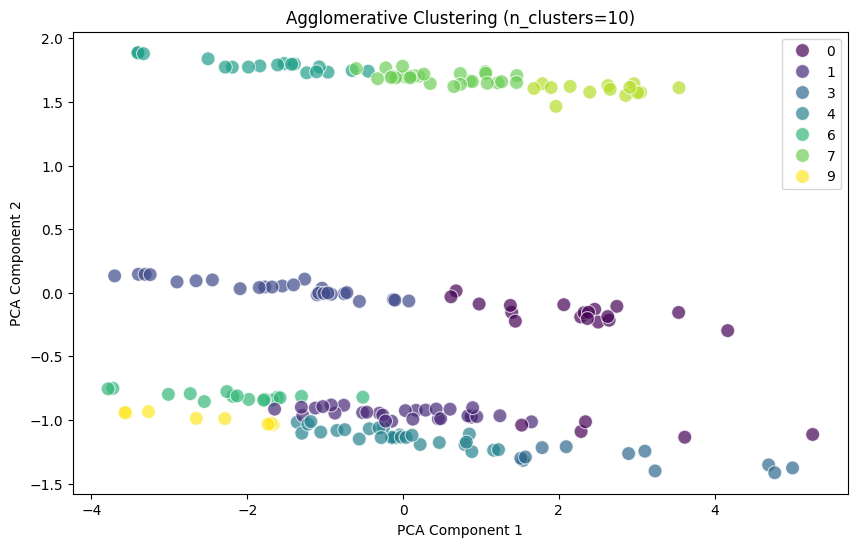

In [27]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Initialize PCA for visualization
pca = PCA(n_components=2)

# Try different values of n_clusters
cluster_numbers = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in cluster_numbers:
    # Fit Agglomerative Clustering with n_clusters
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    agg_labels = agg_clustering.fit_predict(scaled_features)

    # Evaluate clustering
    db_index = davies_bouldin_score(scaled_features, agg_labels)
    silhouette_avg = silhouette_score(scaled_features, agg_labels)

    # Print results for each number of clusters
    print(f"Number of Clusters: {n_clusters}")
    print(f"DB Index: {db_index}")
    print(f"Silhouette Score: {silhouette_avg}\n")

    # Visualize clusters with PCA
    pca_result = pca.fit_transform(scaled_features)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=agg_labels, palette='viridis', s=100, alpha=0.7)
    plt.title(f'Agglomerative Clustering (n_clusters={n_clusters})')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()


#Recommendation:

For most stable and well-separated clusters, K-Means (9 clusters) and Agglomerative Clustering (10 clusters) both perform well based on DB Index and Silhouette Score.

DBSCAN has limitations with the clustering quality, as indicated by the high DB Index and lower Silhouette Score in most cases.

the best performing clustering models based on the DB Index and Silhouette Score:

1. Agglomerative Clustering (10 clusters)
2. K-Means (9 clusters)

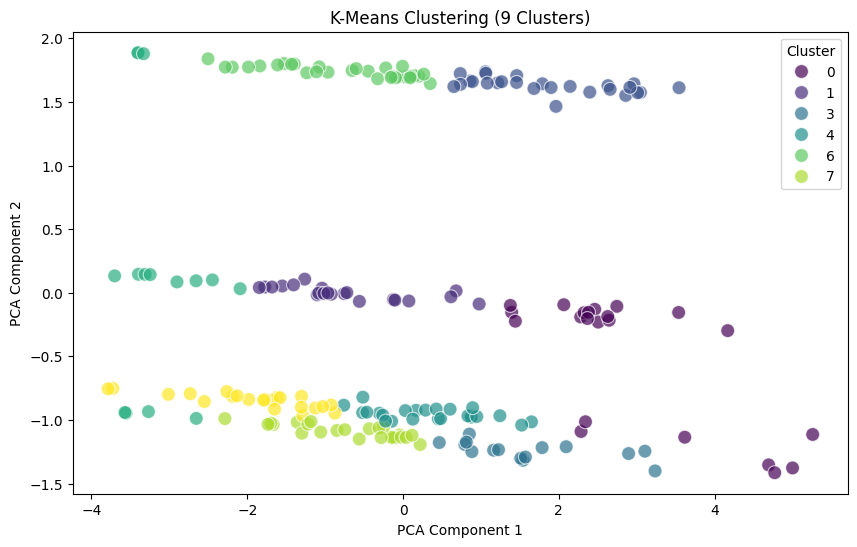

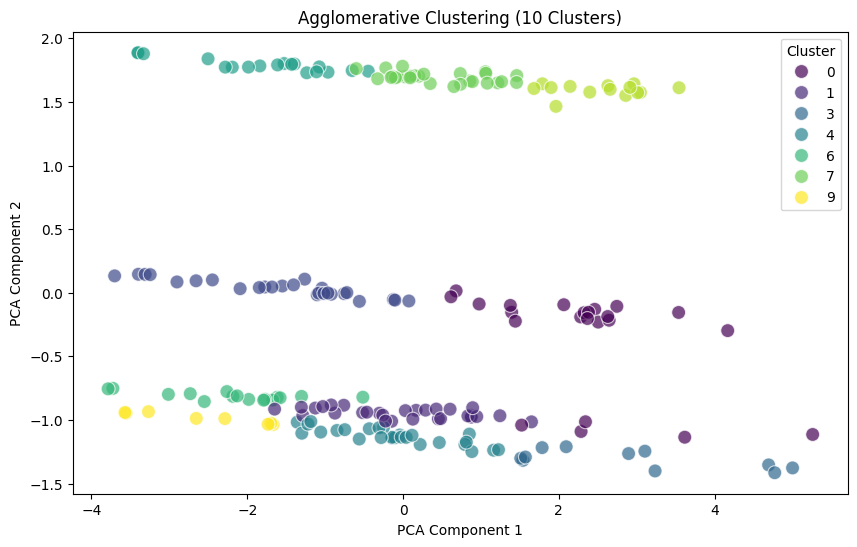

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

# Use PCA to reduce features to 2D for visualization
pca = PCA(n_components=2)
scaled_features_2d = pca.fit_transform(scaled_features)

# K-Means (9 clusters) Visualization
kmeans = KMeans(n_clusters=9, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_features_2d[:, 0], y=scaled_features_2d[:, 1], hue=kmeans_labels, palette='viridis', s=100, alpha=0.7)
plt.title('K-Means Clustering (9 Clusters)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()

# Agglomerative Clustering (10 clusters) Visualization
agg_clust = AgglomerativeClustering(n_clusters=10)
agg_labels = agg_clust.fit_predict(scaled_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_features_2d[:, 0], y=scaled_features_2d[:, 1], hue=agg_labels, palette='viridis', s=100, alpha=0.7)
plt.title('Agglomerative Clustering (10 Clusters)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()
